# Notebook 4 — Parameter Robustness

**Goal.** Check that the strategy’s edge is not a lucky setting.  
We’ll sweep parameters and compare **Profit Factor**, **Expectancy ($/trade)**, and **Max Drawdown**.

**Plan for this notebook**
- **4.1** Setup & helpers (reuse data, add a temporary override context).
- **4.2** **Entry time** sweep (10:10 → 10:35).
- (Next) **4.3** Zone cutoffs (top/bottom %) sweep.
- (Next) **4.4** SL/TP grid.
w
**Train/Test mindset (no ML):** We’ll do sweeps on a **training period** first (2020–2021) and later confirm on 2022–2023.


## What to expect
- Audience: strategy/markets readers; we sweep parameters to see if results hold up around the baseline.
- Inputs: `valid_days.csv` (audited dates), configs in `config/*.yml`, and the core functions from Notebook 3 (`execute_day`).
- Outputs: sweep tables/plots for entry time (and placeholders to add zones and SL/TP), saved to `reports/tables/` and `reports/figures/`.
- Flow: set up → run entry-time sweep on training years → read the table/plots → pick candidates to re-test on 2022–2023.
- You do **not** edit parameters here permanently; use the sweep overrides and adjust YAML if you choose new defaults.


## Inputs & outputs
- **Inputs:**
  - `reports/tables/valid_days.csv` (from Notebook 2; we split into train 2020–2021 vs. test 2022–2023).
  - `data/raw/*.csv` minute data (already parsed by the core loader).
  - `execute_day` imported from `src/or_core` (built in Notebook 3).
- **Outputs (saved):**
  - `reports/tables/entry_time_sweep.csv` (PF, expectancy, max DD per entry time, training set).
  - Figures (if you save them manually) for PF/expectancy/DD vs. entry time.
- **Next:** reuse the same pattern to sweep **zone cutoffs** and **SL/TP grids**, then re-run the best combos on the test years (2022–2023).


### 4.1 — Setup & helpers (what we’re doing here)

* **Purpose:** prepare the environment so later sections (4.2–4.4) can sweep parameters without noisy output.
* **What this cell sets up:**

  1. Paths to `reports/tables/` and loading **valid\_days** (from memory if it exists, otherwise from `valid_days.csv`).
  2. Split the data into a **training window (2020–2021)** we’ll use for sweeps first, and keep **2022–2023** aside for later confirmation.
  3. A small set of **constants** (e.g., `POINT_VAL`, `init_capital`) with safe fallbacks.
  4. Two tiny **helpers**:

     * `mute_everything()` — silences prints/plots so sweeps don’t spam output.
     * `temporary_strategy_overrides(...)` — lets us *temporarily* tweak strategy params (entry time, zone %s, SL/TP) during a sweep without permanently changing your config.
     * `_execute_with_overrides(...)` — passes overrides into `execute_day` if it supports them; otherwise relies on the temporary config override.
* **No backtest loops run in this step.** We’re only preparing.
* **Quick sanity print** at the end shows how many training vs. test days we have (from `valid_days`).

In [1]:
from pathlib import Path
import sys

# 1) Compute project ROOT no matter where the notebook runs from
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))  # put project root on import path first

# 2) Quick diagnostics (helps catch typos/locations)
print("CWD:", Path.cwd())
print("ROOT:", ROOT)
print("src exists:", (ROOT / "src").exists())
print("or_core exists:", (ROOT / "src" / "or_core.py").exists())

# 3) Import the core (module + function)
from src import or_core              # module (lets us tweak or_core.ENTRY_T, etc.)
from src.or_core import execute_day  # function


CWD: d:\Projects\OpeningRange\notebooks
ROOT: d:\Projects\OpeningRange
src exists: True
or_core exists: True


In [2]:
# 4.1 — Setup & helpers

from pathlib import Path
import pandas as pd
import numpy as np
import inspect
from contextlib import contextmanager

# --- Paths
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPORTS_TBLS = ROOT / "reports" / "tables"
REPORTS_TBLS.mkdir(parents=True, exist_ok=True)

# --- Load audited days (from Notebook 2) or CSV
try:
    valid_days
    vd = valid_days.copy()
except NameError:
    vd = pd.read_csv(REPORTS_TBLS / "valid_days.csv", parse_dates=["date"])

vd = vd.sort_values("date").reset_index(drop=True)
vd["year"] = vd["date"].dt.year

# --- Define train/test years (we’ll sweep on TRAIN first)
TRAIN_YEARS = {2020, 2021}
TEST_YEARS  = {2022, 2023}

vd_train = vd[vd["year"].isin(TRAIN_YEARS)].copy()
vd_test  = vd[vd["year"].isin(TEST_YEARS)].copy()

# --- Pull constants (safe fallbacks)
try:
    POINT_VAL = INSTR["market"]["point_value_usd"]
except Exception:
    POINT_VAL = 80.0

try:
    init_capital
except NameError:
    init_capital = 100_000.0

# --- Helper to silence prints/plots during sweeps
import io, IPython.display as ipd
from contextlib import redirect_stdout, redirect_stderr

@contextmanager
def mute_everything():
    buf_out, buf_err = io.StringIO(), io.StringIO()
    orig_ipd_display = ipd.display
    orig_global_display = globals().get("display", None)
    try:
        ipd.display = lambda *a, **k: None
        if orig_global_display is not None:
            globals()["display"] = lambda *a, **k: None
        with redirect_stdout(buf_out), redirect_stderr(buf_err):
            yield
    finally:
        ipd.display = orig_ipd_display
        if orig_global_display is not None:
            globals()["display"] = orig_global_display

# --- Temporary overrides for strategy params (non-destructive)
def _set_nested(d, path, value):
    cur = d
    for k in path[:-1]:
        if not isinstance(cur, dict) or k not in cur:
            return False
        cur = cur[k]
    if isinstance(cur, dict) and path[-1] in cur:
        cur[path[-1]] = value
        return True
    return False

@contextmanager
def temporary_strategy_overrides(entry_time=None, bot_pct=None, top_pct=None, sl_pts=None, tp_pts=None):
    """
    Temporarily modify STRATEGY dict for sweeps. If STRATEGY isn't present,
    we’ll pass overrides directly to execute_day (next helper).
    """
    backup = None
    try:
        if "STRATEGY" in globals() and isinstance(STRATEGY, dict):
            import copy
            backup = copy.deepcopy(STRATEGY)
            if entry_time is not None:
                _set_nested(STRATEGY, ["rules","entry","time"], entry_time)
            if bot_pct is not None:
                _set_nested(STRATEGY, ["rules","zones","bottom_pct"], float(bot_pct))
            if top_pct is not None:
                _set_nested(STRATEGY, ["rules","zones","top_pct"], float(top_pct))
            if sl_pts is not None:
                _set_nested(STRATEGY, ["rules","risk","sl_points"], int(sl_pts))
            if tp_pts is not None:
                _set_nested(STRATEGY, ["rules","risk","tp_points"], int(tp_pts))
        yield
    finally:
        if backup is not None:
            STRATEGY.clear()
            STRATEGY.update(backup)

def _execute_with_overrides(date_str, **overrides):
    """
    Call execute_day with overrides if it accepts them; otherwise rely on
    temporary_strategy_overrides having already set STRATEGY.
    """
    sig = inspect.signature(execute_day)
    kwargs = {}
    for k in ["entry_time", "bot_pct", "top_pct", "sl_pts", "tp_pts", "overrides"]:
        if k in sig.parameters and overrides.get(k) is not None:
            kwargs[k] = overrides[k]
    return execute_day(date_str, **kwargs)

# --- Minimal sanity print
print(f"Training window days (2020–2021): {len(vd_train)}")
print(f"Test window days     (2022–2023): {len(vd_test)}")
print(f"Point value used: ${POINT_VAL:.2f} per point | Initial capital: ${init_capital:,.0f}")


Training window days (2020–2021): 510
Test window days     (2022–2023): 392
Point value used: $80.00 per point | Initial capital: $100,000


### 4.2 — Entry-time sweep (training 2020–2021)

**Why:** Entry timing can change signal quality a lot; we want to see whether performance is stable around 10:22.
**What we vary:** the **entry time** only → `10:10, 10:15, 10:20, 10:22, 10:25, 10:30, 10:35`.
**What we hold fixed:** zones = **top/bottom 35%**, **SL = 25 pts**, **TP = 75 pts** (your baseline).
**Metrics we report:**

* **Profit Factor** (sum of wins ÷ |sum of losses|) on trade days only
* **Expectancy (\$/trade)** (average P\&L per executed trade)
* **Max Drawdown (USD)** from the equity built on those days
  **Scope:** Training window only (**2020–2021**), **gross** P\&L (no costs) for a clean *relative* comparison.
  **Implementation notes:** Uses the `execute_day(...)` you already built, silences inner prints/plots, and returns a small summary table + three light line charts.

d:\Projects\OpeningRange\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Entry-time sweep (training):  86%|████████▌ | 6/7 [00:19<00:02,  2.87s/it]C:\Users\Mbaka\AppData\Local\Temp\ipykernel_2632\2071862055.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["pnl_usd_filled"] = df["pnl_usd"].fillna(0.0)
Entry-time sweep (training): 100%|██████████| 7/7 [00:21<00:00,  3.02s/it]


,entry_time,trades,pf,exp_usd,max_dd
0,10:10,398,1.375859,434.630352,32334.08
1,10:15,398,1.311553,374.602211,41987.20
2,10:20,416,1.366563,436.296154,39816.64
3,10:22,418,1.355541,413.697608,43808.48
4,10:25,415,1.199542,237.100337,54827.68
5,10:30,431,1.286894,326.328353,37474.08
6,7:35,0,NaN,NaN,0.00


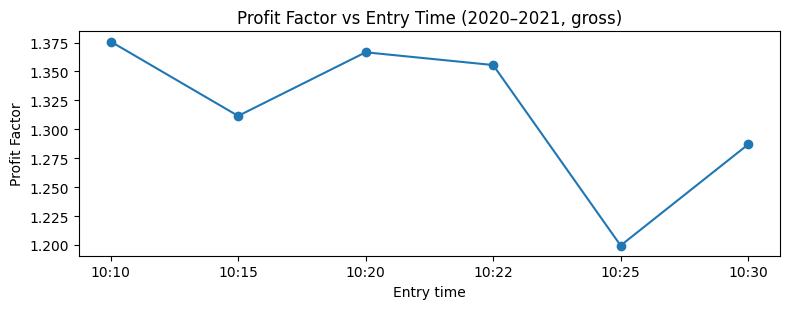

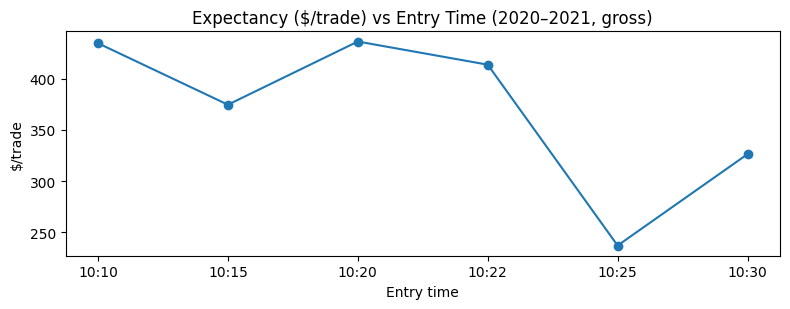

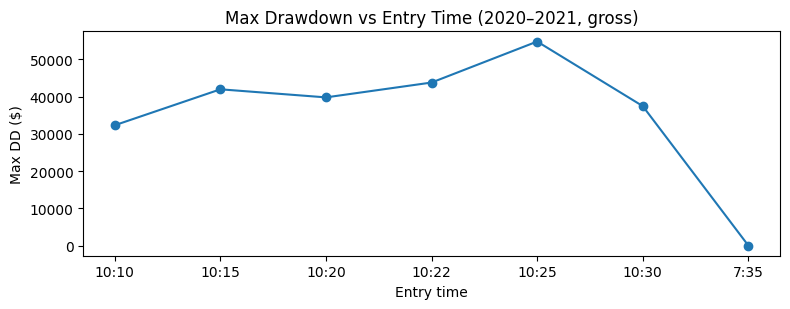

In [ ]:
# 4.2 — Entry-time sweep (training 2020–2021)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import inspect
from src import or_core
from src.or_core import execute_day

# --- safety: require execute_day from Notebook 3
if "execute_day" not in globals():
    raise RuntimeError("Missing `execute_day`. Please run Notebook 3 (sections 3.2–3.5) first.")

# --- helper to call execute_day with overrides if supported
def _execute_with_overrides(date_str, **overrides):
    sig = inspect.signature(execute_day)
    kwargs = {}
    for k in ["entry_time", "bot_pct", "top_pct", "sl_pts", "tp_pts", "overrides"]:
        if k in sig.parameters and overrides.get(k) is not None:
            kwargs[k] = overrides[k]
    return execute_day(date_str, **kwargs)

# --- one run for a given entry time (zones/sl/tp fixed)
def run_backtest_for_params(dates, entry_time, bot_pct=0.35, top_pct=0.35, sl_pts=25, tp_pts=75):
    records = []
    # temporarily override config if STRATEGY dict exists; otherwise pass via kwargs
    with temporary_strategy_overrides(entry_time=entry_time, bot_pct=bot_pct, top_pct=top_pct,
                                      sl_pts=sl_pts, tp_pts=tp_pts):
        for d in dates:
            with mute_everything():
                ex = _execute_with_overrides(d, entry_time=entry_time, bot_pct=bot_pct,
                                             top_pct=top_pct, sl_pts=sl_pts, tp_pts=tp_pts)
            records.append({"date": d, "decision": ex.decision, "pnl_usd": ex.pnl_usd})
    df = pd.DataFrame.from_records(records)
    df["pnl_usd_filled"] = df["pnl_usd"].fillna(0.0)
    df = df.sort_values("date").reset_index(drop=True)

    # KPIs on executed trades
    is_trade = df["decision"].isin(["long","short"])
    trades   = df[is_trade]
    wins     = trades["pnl_usd"] > 0
    losses   = trades["pnl_usd"] < 0
    sum_w = trades.loc[wins,  "pnl_usd"].sum()
    sum_l = -trades.loc[losses, "pnl_usd"].sum()
    pf = (sum_w / sum_l) if sum_l > 0 else np.nan
    exp_usd = trades["pnl_usd"].mean() if len(trades) else np.nan

    # equity & drawdown (gross)
    eq = init_capital + df["pnl_usd_filled"].cumsum()
    dd = (eq.cummax() - eq).astype(float)
    max_dd = float(dd.max()) if len(dd) else np.nan

    return {"trades": int(is_trade.sum()), "pf": float(pf), "exp_usd": float(exp_usd), "max_dd": max_dd}

# --- run the sweep on training dates
ENTRY_GRID = ["10:10","10:15","10:20","10:22","10:25","10:30","10:35"]
dates_train = vd_train["date"].dt.strftime("%Y-%m-%d").tolist()

rows = []
for et in tqdm(ENTRY_GRID, desc="Entry-time sweep (training)"):
    or_core.ENTRY_T = et
    k = run_backtest_for_params(dates_train, entry_time=et, bot_pct=0.35, top_pct=0.35, sl_pts=25, tp_pts=75)
    k["entry_time"] = et
    rows.append(k)

sweep_et = pd.DataFrame(rows).sort_values("entry_time").reset_index(drop=True)
display(sweep_et[["entry_time","trades","pf","exp_usd","max_dd"]])

# --- small visuals
plt.figure(figsize=(8,3.2))
plt.plot(sweep_et["entry_time"], sweep_et["pf"], marker="o")
plt.title("Profit Factor vs Entry Time (2020–2021, gross)")
plt.xlabel("Entry time"); plt.ylabel("Profit Factor")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3.2))
plt.plot(sweep_et["entry_time"], sweep_et["exp_usd"], marker="o")
plt.title("Expectancy ($/trade) vs Entry Time (2020–2021, gross)")
plt.xlabel("Entry time"); plt.ylabel("$/trade")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3.2))
plt.plot(sweep_et["entry_time"], sweep_et["max_dd"], marker="o")
plt.title("Max Drawdown vs Entry Time (2020–2021, gross)")
plt.xlabel("Entry time"); plt.ylabel("Max DD ($)")
plt.tight_layout(); plt.show()


In [ ]:
# 4.2A — Save sweep results & highlight candidates
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPORTS_TBLS = ROOT / "reports" / "tables"
REPORTS_TBLS.mkdir(parents=True, exist_ok=True)

try:
    sweep_et
except NameError:
    print("Run 4.2 first to build sweep_et.")
else:
    out_path = REPORTS_TBLS / "entry_time_sweep.csv"
    sweep_et.to_csv(out_path, index=False)
    print("Saved entry-time sweep ->", out_path)

    # Highlight by Profit Factor and Expectancy (training set)
    pf_sorted = sweep_et.sort_values("pf", ascending=False)
    exp_sorted = sweep_et.sort_values("exp_usd", ascending=False)
    print("
Top 3 by Profit Factor:")
    display(pf_sorted.head(3)[["entry_time","trades","pf","exp_usd","max_dd"]])
    print("
Top 3 by Expectancy ($/trade):")
    display(exp_sorted.head(3)[["entry_time","trades","pf","exp_usd","max_dd"]])


## Quick read (fill after running)
- Best entry times by Profit Factor: ____; by Expectancy: ____.
- Stability: Are neighboring times (e.g., 10:20–10:30) similar, or is there a single spike?
- Drawdown awareness: Which entry times balloon max DD? Note trades count (low trades can inflate PF).
- Action: pick 2–3 candidate times (e.g., baseline 10:22 plus a neighbor) to retest on **2022–2023**.


### 4.3 — Zone sweep (top/bottom %)
- **Why:** Check if the edge persists when we widen/narrow the opening-range bands.
- **Vary:** `top_pct`/`bottom_pct` ∈ {0.25, 0.30, 0.35, 0.40, 0.45} (symmetric).
- **Hold:** entry time = baseline 10:22; SL/TP = 25/75 pts.
- **Metrics:** Profit Factor, Expectancy ($/trade), Max DD (USD), trade count (training 2020–2021).


In [ ]:
# 4.3 — Zone sweep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from src import or_core

ZONES = [0.25, 0.30, 0.35, 0.40, 0.45]
dates_train = vd_train["date"].dt.strftime("%Y-%m-%d").tolist()

zone_rows = []
for z in tqdm(ZONES, desc="Zone sweep (training)"):
    k = run_backtest_for_params(dates_train, entry_time="10:22", bot_pct=z, top_pct=z, sl_pts=25, tp_pts=75)
    k["zone_pct"] = z
    zone_rows.append(k)

sweep_zones = pd.DataFrame(zone_rows).sort_values("zone_pct").reset_index(drop=True)
display(sweep_zones[["zone_pct","trades","pf","exp_usd","max_dd"]])

plt.figure(figsize=(8,3))
plt.plot(sweep_zones["zone_pct"], sweep_zones["pf"], marker="o")
plt.title("Profit Factor vs Zone % (2020–2021, gross)")
plt.xlabel("Top/Bottom zone % of OR")
plt.ylabel("Profit Factor")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3))
plt.plot(sweep_zones["zone_pct"], sweep_zones["exp_usd"], marker="o")
plt.title("Expectancy ($/trade) vs Zone % (2020–2021, gross)")
plt.xlabel("Top/Bottom zone % of OR")
plt.ylabel("$/trade")
plt.tight_layout(); plt.show()


In [ ]:
# 4.3A — Save zone sweep & highlight
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPORTS_TBLS = ROOT / "reports" / "tables"
REPORTS_TBLS.mkdir(parents=True, exist_ok=True)

try:
    sweep_zones
except NameError:
    print("Run 4.3 first to build sweep_zones.")
else:
    out_path = REPORTS_TBLS / "zone_sweep.csv"
    sweep_zones.to_csv(out_path, index=False)
    print("Saved zone sweep ->", out_path)

    pf_sorted = sweep_zones.sort_values("pf", ascending=False)
    exp_sorted = sweep_zones.sort_values("exp_usd", ascending=False)
    print("
Top 3 by Profit Factor:")
    display(pf_sorted.head(3)[["zone_pct","trades","pf","exp_usd","max_dd"]])
    print("
Top 3 by Expectancy ($/trade):")
    display(exp_sorted.head(3)[["zone_pct","trades","pf","exp_usd","max_dd"]])


### 4.4 — SL/TP grid
- **Why:** Test payoff vs win-rate trade-offs around the baseline 25/75.
- **Vary:** `SL` ∈ {20, 25, 30} pts; `TP` ∈ {60, 75, 90} pts.
- **Hold:** entry time = 10:22; zones = 35%/35%.
- **Metrics:** Profit Factor, Expectancy ($/trade), Max DD (USD), trade count (training 2020–2021).


In [ ]:
# 4.4 — SL/TP grid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

SL_GRID = [20, 25, 30]
TP_GRID = [60, 75, 90]
dates_train = vd_train["date"].dt.strftime("%Y-%m-%d").tolist()

sl_tp_rows = []
for sl in SL_GRID:
    for tp in TP_GRID:
        k = run_backtest_for_params(dates_train, entry_time="10:22", bot_pct=0.35, top_pct=0.35, sl_pts=sl, tp_pts=tp)
        k.update({"sl_pts": sl, "tp_pts": tp, "rr": tp / sl if sl else np.nan})
        sl_tp_rows.append(k)

sweep_sl_tp = pd.DataFrame(sl_tp_rows).sort_values(["sl_pts","tp_pts"]).reset_index(drop=True)
display(sweep_sl_tp[["sl_pts","tp_pts","rr","trades","pf","exp_usd","max_dd"]])

# Heatmaps for PF and Expectancy
pf_pivot = sweep_sl_tp.pivot(index="sl_pts", columns="tp_pts", values="pf")
exp_pivot = sweep_sl_tp.pivot(index="sl_pts", columns="tp_pts", values="exp_usd")

fig, ax = plt.subplots(1,2, figsize=(10,4))
im0 = ax[0].imshow(pf_pivot.values, aspect="auto", cmap="coolwarm")
ax[0].set_xticks(range(len(pf_pivot.columns))); ax[0].set_xticklabels(pf_pivot.columns)
ax[0].set_yticks(range(len(pf_pivot.index))); ax[0].set_yticklabels(pf_pivot.index)
ax[0].set_title("Profit Factor")
ax[0].set_xlabel("TP (pts)"); ax[0].set_ylabel("SL (pts)")
fig.colorbar(im0, ax=ax[0], shrink=0.8)

im1 = ax[1].imshow(exp_pivot.values, aspect="auto", cmap="coolwarm")
ax[1].set_xticks(range(len(exp_pivot.columns))); ax[1].set_xticklabels(exp_pivot.columns)
ax[1].set_yticks(range(len(exp_pivot.index))); ax[1].set_yticklabels(exp_pivot.index)
ax[1].set_title("Expectancy ($/trade)")
ax[1].set_xlabel("TP (pts)"); ax[1].set_ylabel("SL (pts)")
fig.colorbar(im1, ax=ax[1], shrink=0.8)
plt.tight_layout(); plt.show()


In [ ]:
# 4.4A — Save SL/TP sweep & highlight
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPORTS_TBLS = ROOT / "reports" / "tables"
REPORTS_TBLS.mkdir(parents=True, exist_ok=True)

try:
    sweep_sl_tp
except NameError:
    print("Run 4.4 first to build sweep_sl_tp.")
else:
    out_path = REPORTS_TBLS / "sl_tp_sweep.csv"
    sweep_sl_tp.to_csv(out_path, index=False)
    print("Saved SL/TP sweep ->", out_path)

    pf_sorted = sweep_sl_tp.sort_values("pf", ascending=False)
    exp_sorted = sweep_sl_tp.sort_values("exp_usd", ascending=False)
    print("
Top 3 by Profit Factor:")
    display(pf_sorted.head(3)[["sl_pts","tp_pts","rr","trades","pf","exp_usd","max_dd"]])
    print("
Top 3 by Expectancy ($/trade):")
    display(exp_sorted.head(3)[["sl_pts","tp_pts","rr","trades","pf","exp_usd","max_dd"]])


## Next steps
- Re-test the **top entry/zone/SL-TP combos** on the 2022–2023 test window; compare PF/expectancy/DD vs training.
- Pick a final parameter set and update `config/strategy.yml` if you want it as the new baseline.
- Re-run Notebooks 03–05 with the chosen params and costs to refresh all reports.
- Optional: add walk-forward or bootstrapped trade-order shuffles to probe robustness further.
